In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings
import seaborn as sns

<h1>Hyperparameters<h1>


In [235]:
K = 5 # validation folds
MIN_LAG = 120
MAX_LAG = 144
SEED = 42
VAL_SPLIT = 0.2

In [236]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [237]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [238]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs

In [239]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [240]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    DFS[i].index = pd.to_datetime(DFS[i].index)
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<h1>Training<h1>

In [241]:
# k-Fold for validation
k = K
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [242]:
def cross_validate(data,alpha1,alpha2,mu,sig):
    mape_values = []
    L = len(data)
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[offset:int(offset + np.floor(L/k))]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        model1 = Lasso(alpha = alpha1,max_iter=200,tol=10**(-3))
        model1.fit(X_train, y1_train)
        y1_pred = model1.predict(X_val)

        model2 = Lasso(alpha = alpha2,max_iter=200,tol=10**(-3))
        model2.fit(X_train, y2_train)
        y2_pred = model2.predict(X_val)

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
        # Averaging MAPE across all folds
    return average_mape

Oslo
Alpha1, alpha2 --> MAPE
5.960464477539063e-08 0.000244140625 --> 0.4551009814624809
5.960464477539063e-08 0.00048828125 --> 0.5544382569910337
5.960464477539063e-08 0.0009765625 --> 0.7495758236114622
2.384185791015625e-07 0.000244140625 --> 0.45451536824678446
2.384185791015625e-07 0.00048828125 --> 0.5539617636219728
2.384185791015625e-07 0.0009765625 --> 0.7497717275165794
9.5367431640625e-07 0.000244140625 --> 0.4546844015840006
9.5367431640625e-07 0.00048828125 --> 0.5541175016358052
9.5367431640625e-07 0.0009765625 --> 0.7497502539099775
Best Hyperparameters: (2.384185791015625e-07, 0.000244140625)
Best CV MAPE: 0.45451536824678446%


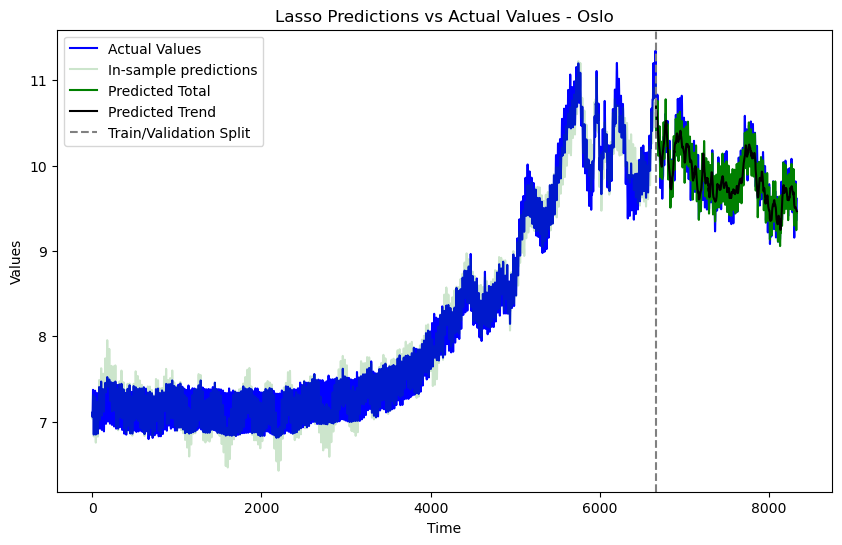

Out of sample MAPE: 0.957974255554283
Mean oveprediction: 1.0000376995821343
Mean underprediction: 0.9209432325952261
MAPE with trend prediction only: 1.5986699697615288
Intercept: 
6.949278027726663
Coefficients: 
is_holiday: 0.08420159384432674
is_weekend: 0.058806833453464644
hour: 0.0012050089823413138
month: 0.10418007221098544
temperature_seasonal: 0.13141490743337667
spot_price_seasonal: 0.05819285908051569
temperature_trend_L118: 0.04100704910158238
temperature_trend_L119: 0.042848013696049854
temperature_trend_L120: 0.036434344456984576
temperature_trend_L121: 0.030123470389274185
temperature_trend_L122: 0.023651209385684265
temperature_trend_L123: 0.01715866274285538
temperature_trend_L124: 0.01499313227575977
temperature_trend_L125: 0.008940812407694647
temperature_trend_L126: 0.003041135533593751
temperature_trend_L142: 0.0646704058905522
temperature_trend_L143: 0.09114893232173615
temperature_trend_L144: 0.11082531186527503
temperature_seasonal_L24: 0.027117348390428994
te

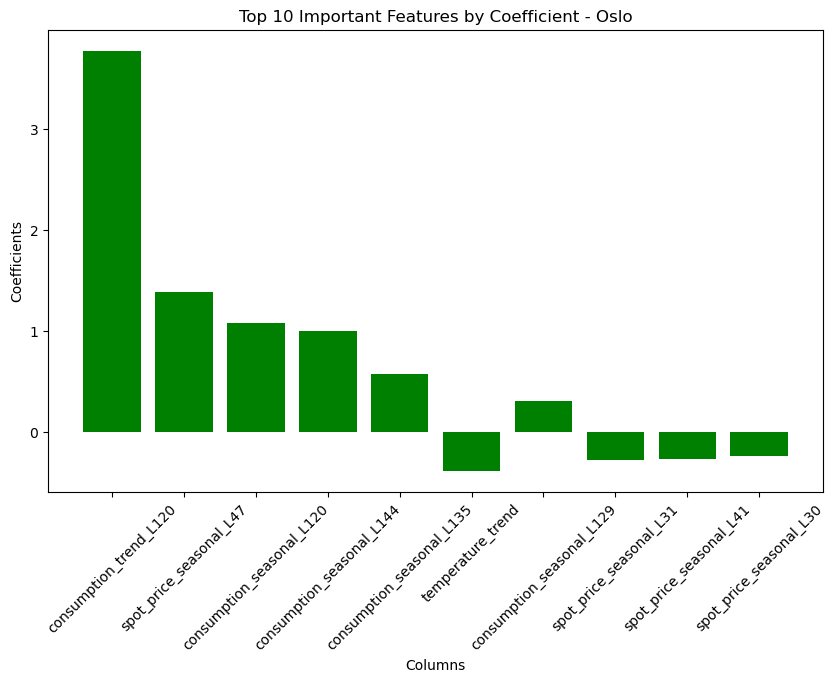

Stavanger
Alpha1, alpha2 --> MAPE
5.960464477539063e-08 0.000244140625 --> 0.8774568986345059
5.960464477539063e-08 0.00048828125 --> 0.8015329069077364
5.960464477539063e-08 0.0009765625 --> 0.6979449906021576
2.384185791015625e-07 0.000244140625 --> 0.8773969695091056
2.384185791015625e-07 0.00048828125 --> 0.8011948914645055
2.384185791015625e-07 0.0009765625 --> 0.6974689464585316
9.5367431640625e-07 0.000244140625 --> 0.8785481350094851
9.5367431640625e-07 0.00048828125 --> 0.8020114485654117
9.5367431640625e-07 0.0009765625 --> 0.6980463434923533
Best Hyperparameters: (2.384185791015625e-07, 0.0009765625)
Best CV MAPE: 0.6974689464585316%


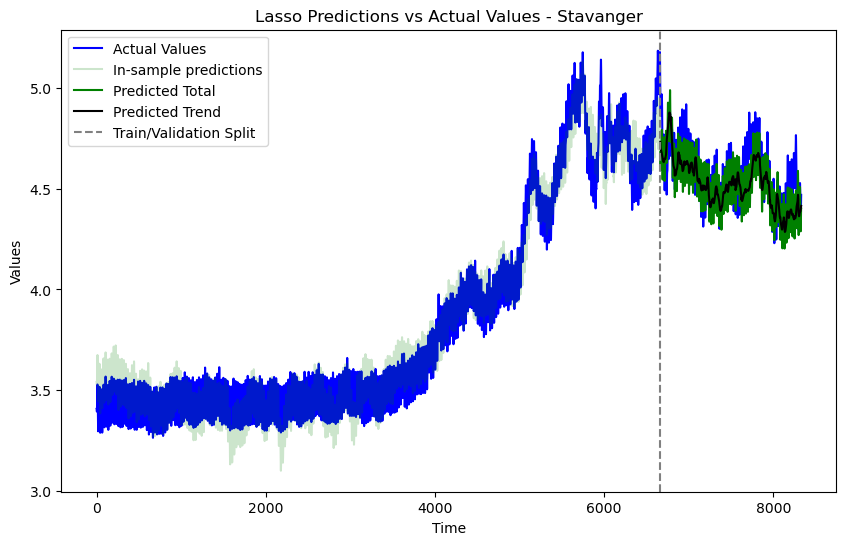

Out of sample MAPE: 1.707967100933792
Mean oveprediction: 1.1547001179784178
Mean underprediction: 1.9286235383005452
MAPE with trend prediction only: 2.0759218268664648
Intercept: 
3.4001548674499906
Coefficients: 
is_holiday: 0.007716021786167897
is_weekend: 0.019037635219171997
hour: 2.0001133690329427e-05
month: 0.11227791885694187
temperature_seasonal: 0.0585787043762065
spot_price_seasonal: 0.20523028385376402
temperature_trend_L125: 0.002131106637097051
temperature_trend_L126: 0.0025435904289399514
temperature_trend_L127: 0.0012424317752518167
temperature_trend_L128: 0.0003019802474534142
temperature_trend_L141: 0.011992500623260047
temperature_trend_L142: 0.01669729662057307
temperature_trend_L143: 0.019927739377837587
temperature_trend_L144: 0.023223392919473614
temperature_seasonal_L24: 0.007051415496037261
temperature_seasonal_L25: 0.03447662982342199
temperature_seasonal_L26: 0.03320264496568658
temperature_seasonal_L27: 0.03724639890015182
temperature_seasonal_L28: 0.05927

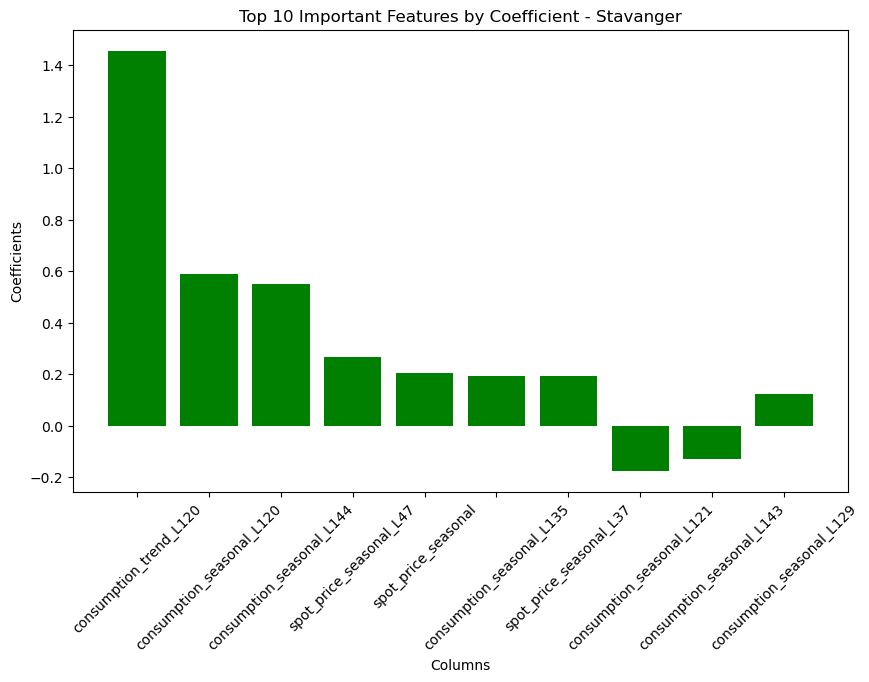

Trondheim
Alpha1, alpha2 --> MAPE
5.960464477539063e-08 0.000244140625 --> 1.1426837837273924
5.960464477539063e-08 0.00048828125 --> 1.2532918268521482
5.960464477539063e-08 0.0009765625 --> 1.3120626597820852
2.384185791015625e-07 0.000244140625 --> 1.1425515215600717
2.384185791015625e-07 0.00048828125 --> 1.2531285006478525
2.384185791015625e-07 0.0009765625 --> 1.3119377308550788
9.5367431640625e-07 0.000244140625 --> 1.1425552049150831
9.5367431640625e-07 0.00048828125 --> 1.253163059266198
9.5367431640625e-07 0.0009765625 --> 1.3119548428718684
Best Hyperparameters: (2.384185791015625e-07, 0.000244140625)
Best CV MAPE: 1.1425515215600717%


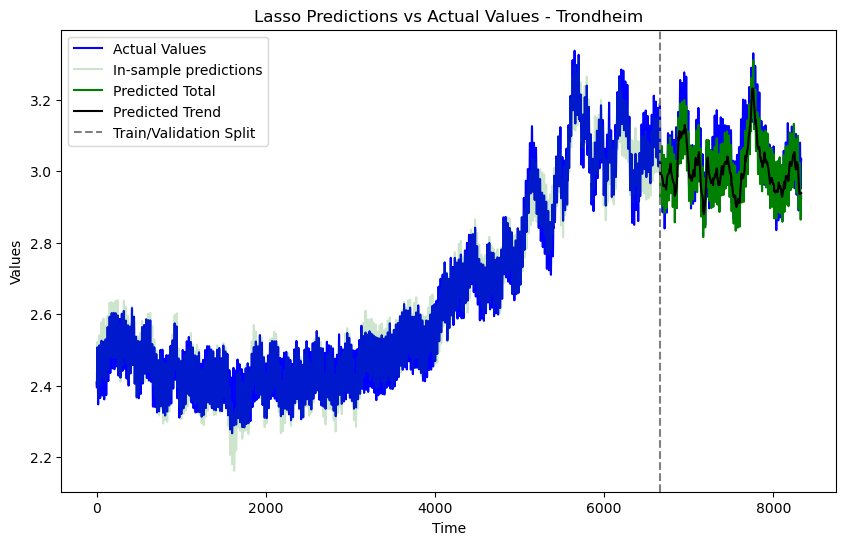

Out of sample MAPE: 1.2863310112782829
Mean oveprediction: 0.5946558360220268
Mean underprediction: 1.50775475993401
MAPE with trend prediction only: 1.8032286305250838
Intercept: 
2.37486422818838
Coefficients: 
is_holiday: 0.00284541936965968
is_weekend: 0.01703382162349439
month: 0.03402144122385284
temperature_seasonal: 0.05567605781710638
temperature_trend_L117: 0.007692091298822206
temperature_trend_L118: 0.010450948280887074
temperature_trend_L119: 0.009544001819098457
temperature_trend_L120: 0.008270157364117228
temperature_trend_L121: 0.006673884625092606
temperature_trend_L122: 0.00491858019072224
temperature_trend_L123: 0.0031495905564514924
temperature_trend_L124: 0.0014783210777107886
temperature_trend_L142: 0.0017826356518897796
temperature_trend_L143: 0.017011734522085868
temperature_trend_L144: 0.020931070686717297
temperature_seasonal_L24: 0.005015113063534457
temperature_seasonal_L25: 0.039488666954017
temperature_seasonal_L26: 0.03027240671731178
temperature_seasonal

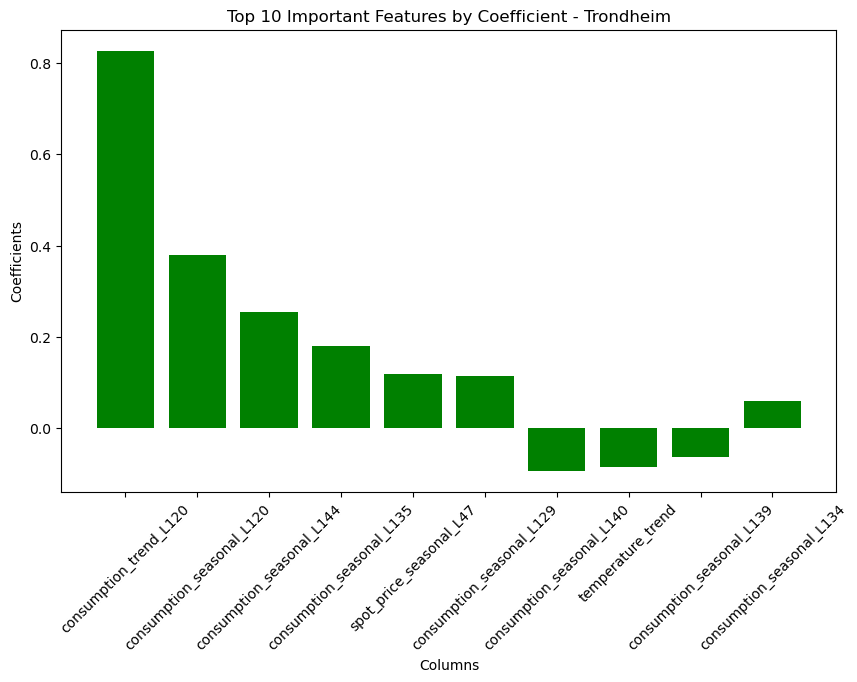

Tromsø
Alpha1, alpha2 --> MAPE
5.960464477539063e-08 0.000244140625 --> 1.0601117285911574
5.960464477539063e-08 0.00048828125 --> 1.0385425876403143
5.960464477539063e-08 0.0009765625 --> 0.9933331780883301
2.384185791015625e-07 0.000244140625 --> 1.0598733365272335
2.384185791015625e-07 0.00048828125 --> 1.0383191054347993
2.384185791015625e-07 0.0009765625 --> 0.9928633223332725
9.5367431640625e-07 0.000244140625 --> 1.0602971019113485
9.5367431640625e-07 0.00048828125 --> 1.0387667128117595
9.5367431640625e-07 0.0009765625 --> 0.99345711010238
Best Hyperparameters: (2.384185791015625e-07, 0.0009765625)
Best CV MAPE: 0.9928633223332725%


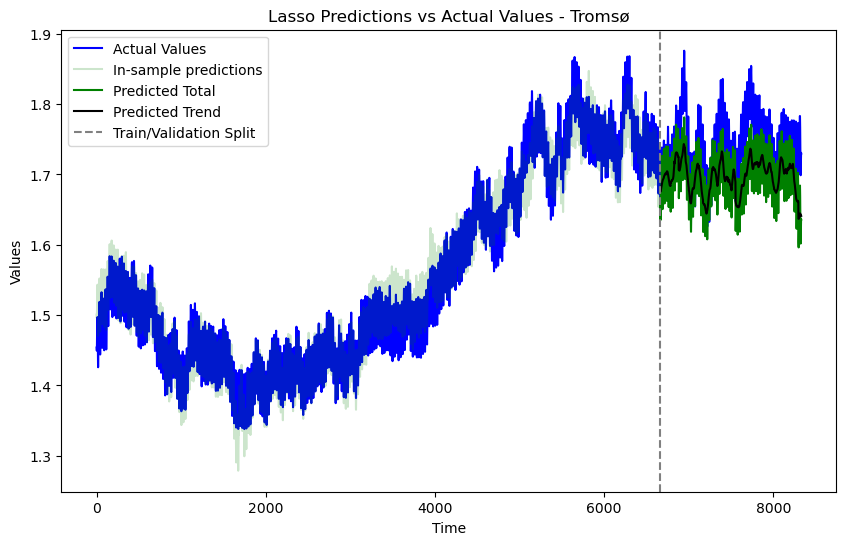

Out of sample MAPE: 2.4933321367036294
Mean oveprediction: 0.09417231325433371
Mean underprediction: 2.538820793906644
MAPE with trend prediction only: 2.65756483641261
Intercept: 
1.6033675443115332
Coefficients: 
is_holiday: 0.003909931469261207
is_weekend: 0.003151496643418225
hour: 9.219071158882878e-05
month: 0.050793574361906645
temperature_seasonal: 0.08132465683152137
spot_price_seasonal: 0.004474380925246679
temperature_trend_L132: 0.0016288640962606575
temperature_trend_L133: 0.0021025444113024466
temperature_trend_L134: 0.0016602051346043284
temperature_trend_L135: 0.0011552057114596027
temperature_trend_L136: 0.0005413056467512218
temperature_seasonal_L24: 0.01437354700938344
temperature_seasonal_L25: 0.04924175973489027
temperature_seasonal_L26: 0.029713039180267027
temperature_seasonal_L27: 0.02197447146572724
temperature_seasonal_L28: 0.035713609791978046
temperature_seasonal_L29: 0.01754862971639544
temperature_seasonal_L30: 0.044514168861771626
temperature_seasonal_L31

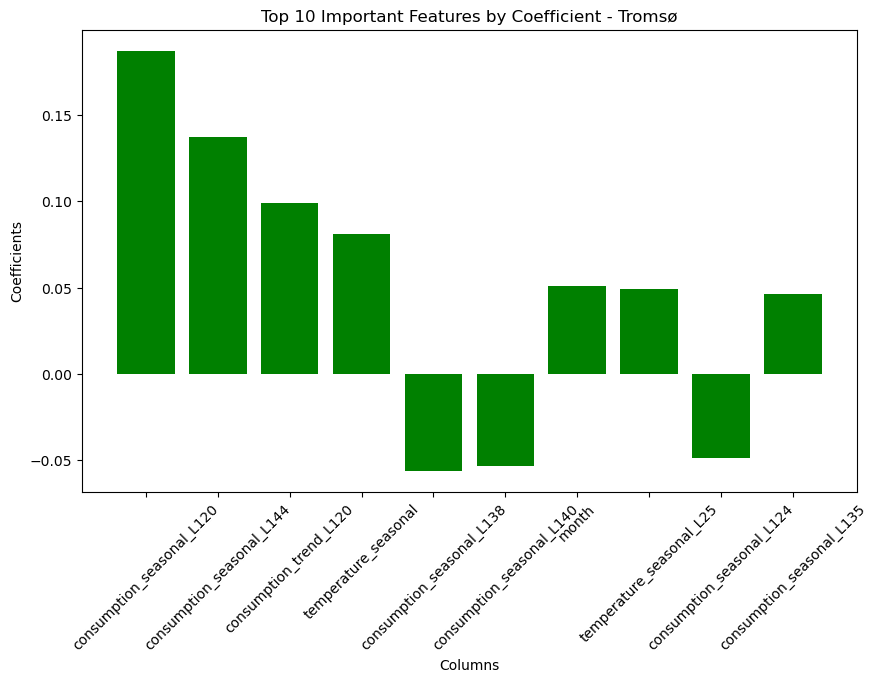

Bergen
Alpha1, alpha2 --> MAPE
5.960464477539063e-08 0.000244140625 --> 0.9519134111342399
5.960464477539063e-08 0.00048828125 --> 0.9465907283291704
5.960464477539063e-08 0.0009765625 --> 1.012578934064593
2.384185791015625e-07 0.000244140625 --> 0.952964047657148
2.384185791015625e-07 0.00048828125 --> 0.9470358058919971
2.384185791015625e-07 0.0009765625 --> 1.013169624264032
9.5367431640625e-07 0.000244140625 --> 0.9537717605265543
9.5367431640625e-07 0.00048828125 --> 0.9474093618864542
9.5367431640625e-07 0.0009765625 --> 1.0134157009286824
Best Hyperparameters: (5.960464477539063e-08, 0.00048828125)
Best CV MAPE: 0.9465907283291704%


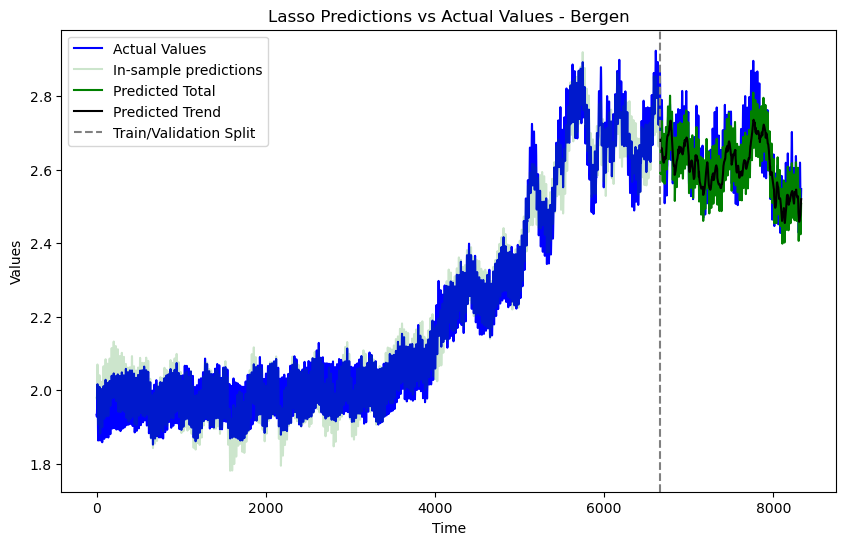

Out of sample MAPE: 1.6092943972273888
Mean oveprediction: 1.1172682897474893
Mean underprediction: 1.8319287039249197
MAPE with trend prediction only: 2.1008216189805853
Intercept: 
1.9643220259833298
Coefficients: 
is_holiday: 0.020023989889918516
is_weekend: 0.014579681244181662
month: 0.042734899136209814
temperature_seasonal: 0.053802663808336995
spot_price_seasonal: 0.8404815965497787
temperature_trend_L119: 0.007894402310089048
temperature_trend_L120: 0.00688000936859864
temperature_trend_L121: 0.005040859273831141
temperature_trend_L122: 0.003529185427402721
temperature_trend_L123: 0.0023640155400230147
temperature_trend_L124: 0.0005944823324157461
temperature_trend_L142: 0.003522288939554638
temperature_trend_L143: 0.018163301146127495
temperature_trend_L144: 0.02198262922527177
temperature_seasonal_L25: 0.025100266151030136
temperature_seasonal_L26: 0.020139155520594882
temperature_seasonal_L27: 0.028646849494574134
temperature_seasonal_L28: 0.02786652236410691
temperature_se

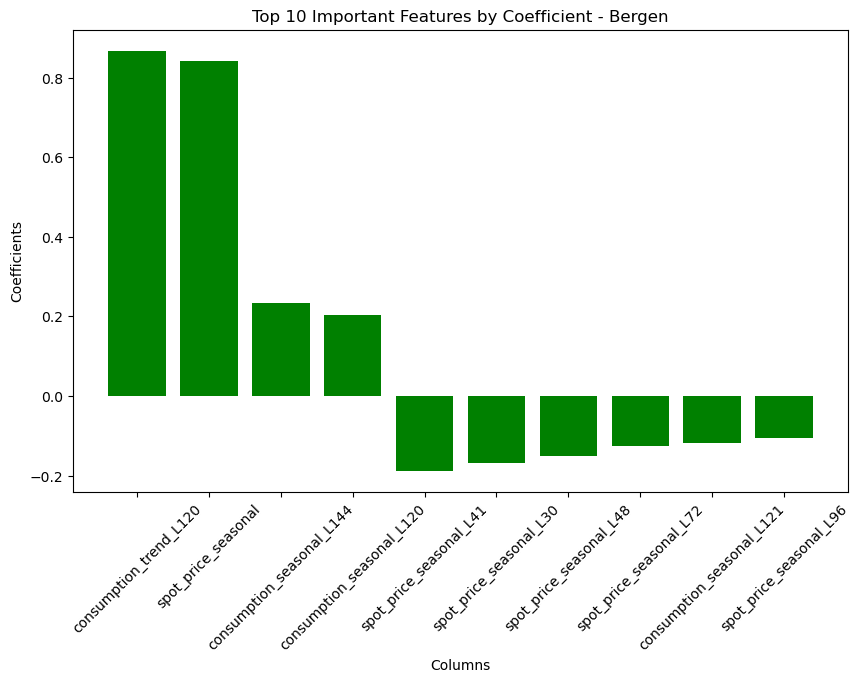

In [243]:
all_models = []
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    alpha1s = [2**(-24),2**(-22),2**(-20)]
    alpha2s = [2**(-12), 2**(-11), 2**(-10)]

    # Grid Search
    best_mape = float('inf')
    best_hyperparams = None

    print("Alpha1, alpha2 --> MAPE")
    for alpha1 in alpha1s:
        for alpha2 in alpha2s:
            average_mape = cross_validate(data,alpha1,alpha2,mu,sig)
            print(f"{alpha1} {alpha2} --> {average_mape}")
            # Update best hyperparameters if current MAPE is lower
            if average_mape < best_mape:
                best_mape = average_mape
                best_hyperparams = (alpha1,alpha2)

    print(f'Best Hyperparameters: {best_hyperparams}')
    print(f'Best CV MAPE: {best_mape}%')

    model1 = Lasso(alpha=best_hyperparams[0])
    model2 = Lasso(alpha=best_hyperparams[1])
    all_models.append([model1,model2])
    X = data
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    thresh = np.floor(len(X) * (1 - VAL_SPLIT))
    X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
    y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
    y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

    model1.fit(X_train, y1_train)
    y1_pred = model1.predict(X_val)
    model2.fit(X_train, y2_train)
    y2_pred = model2.predict(X_val)

    X = DFS[I]
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    train_pred1 = model1.predict(X_train)
    train_pred2 = model2.predict(X_train)

    actual = (y1 + y2)
    full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    # Create an array of indices for plotting
    xs = range(len(actual))
    xs_train = range(len(train_pred1))
    xs_oos = range(len(train_pred1),len(train_pred1)+len(y1_pred))

    # Plot actual values and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(xs, actual * sig + mu, label='Actual Values', color='blue')
    plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='green',alpha=0.2)
    plt.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='green')
    plt.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='black')
    plt.axvline(len(train_pred1), linestyle='--', color='gray', label='Train/Validation Split')
    plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
    oos_MAPE = np.mean(np.abs(resids)) * 100
    error_95 = np.percentile(np.abs(resids),95)
    mape_positive = resids[resids < 0].mean()*-100
    mape_negative = resids[resids > 0].mean()*100
    mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)))*100
    print(f"Out of sample MAPE: {oos_MAPE}")
    print(f"Mean oveprediction: {mape_positive}")
    print(f"Mean underprediction: {mape_negative}")
    print(f"MAPE with trend prediction only: {mape_trend}")

    coefs1 = model1.coef_
    coefs2 = model2.coef_
    cols = X.columns
    coefs_total= (coefs1+coefs2)*sig
    print("Intercept: ")
    print(model1.intercept_+model2.intercept_+mu)
    print("Coefficients: ")
    for i in range(len(cols)):
        if coefs_total[i]>0:
            print(f"{cols[i]}: {coefs_total[i]}")

    combined_list = list(zip(cols, coefs_total))

    # Sorting by the absolute value of coefficients
    sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
    top_10 = sorted_list[:10]
    top_cols, top_coefs = zip(*top_10)
    plt.figure(figsize=(10, 6))
    plt.bar(top_cols, top_coefs, color='green')
    plt.title(f"Top 10 Important Features by Coefficient - {DF_STRINGS[I]}")
    plt.xlabel('Columns')
    plt.ylabel('Coefficients')
    plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
    plt.show()


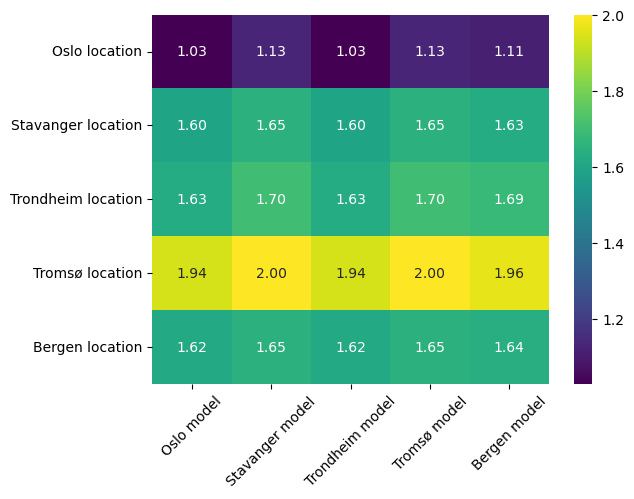

In [245]:
cross_table=np.zeros((5,5))
for I in range(5):
    for J in range(5):
        data = DFS[I]
        model1 = all_models[J][0]
        model1 = all_models[J][1]
        X = data
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

        thresh = np.floor(len(X) * (1 - VAL_SPLIT))
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

        model1.fit(X_train, y1_train)
        y1_pred = model1.predict(X_val)
        model2.fit(X_train, y2_train)
        y2_pred = model2.predict(X_val)
        mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

        resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
        oos_MAPE = np.mean(np.abs(resids)) * 100
        cross_table[I,J]=oos_MAPE

df = pd.DataFrame(cross_table, index=DF_STRINGS, columns=DF_STRINGS)

# Create a heatmap using seaborn
sns.heatmap(df, cmap='viridis', annot=True, fmt=".2f", cbar=True)

# Set labels for the rows and columns with additional text
plt.xticks(np.arange(len(DF_STRINGS)) + 0.5, [f'{label} model' for label in DF_STRINGS], rotation=45)
plt.yticks(np.arange(len(DF_STRINGS)) + 0.5, [f'{label} location' for label in DF_STRINGS], rotation=0)

# Show the plot
plt.show()